<a href="https://colab.research.google.com/github/Juandavidmarint/data-analysis-logistica/blob/main/prediccion_entregas_logistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modelo de predicci√≥n de tiempos de entrega usando Machine Learning

In [1]:
from google.colab import files
uploaded = files.upload()


Saving pedidos_logistica_grande.csv to pedidos_logistica_grande (1).csv


Revisi√≥n inicial de la informaci√≥n

In [2]:
import pandas as pd

# Cargar el archivo
df = pd.read_csv("pedidos_logistica_grande.csv")

# Vista previa de los datos
df.head()


pedido_id fecha_pedido fecha_entrega  producto        origen       destino  \
0          1   2023-04-04    2023-04-10  Pantal√≥n          Lima        Bogot√°   
1          2   2023-08-10    2023-11-12    Camisa    Valpara√≠so  Buenos Aires   
2          3   2023-01-10    2023-04-20  Pantal√≥n          Lima      Medell√≠n   
3          4   2023-08-11    2023-10-15    Camisa  Buenos Aires      Santiago   
4          5   2023-05-07    2023-05-14   Zapatos        Bogot√°      Medell√≠n   

   distancia_km medio_transporte     clima  tiempo_entrega_real  
0          2034            Avi√≥n  Lluvioso                    6  
1          2815            Barco   Nublado                   94  
2          2979            Barco   Nublado                  100  
3          1842            Barco  Tormenta                   65  
4           268             Moto   Nublado                    7

In [3]:
# Informaci√≥n general de columnas y tipos de datos
df.info()

# Estad√≠sticas descriptivas num√©ricas
df.describe()

# Verificar valores nulos
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   pedido_id            10000 non-null  int64 
 1   fecha_pedido         10000 non-null  object
 2   fecha_entrega        10000 non-null  object
 3   producto             10000 non-null  object
 4   origen               10000 non-null  object
 5   destino              10000 non-null  object
 6   distancia_km         10000 non-null  int64 
 7   medio_transporte     10000 non-null  object
 8   clima                10000 non-null  object
 9   tiempo_entrega_real  10000 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 781.4+ KB


pedido_id              0
fecha_pedido           0
fecha_entrega          0
producto               0
origen                 0
destino                0
distancia_km           0
medio_transporte       0
clima                  0
tiempo_entrega_real    0
dtype: int64

In [5]:
print(df.columns)


Index(['pedido_id', 'fecha_pedido', 'fecha_entrega', 'producto', 'origen',
       'destino', 'distancia_km', 'medio_transporte', 'clima',
       'tiempo_entrega_real'],
      dtype='object')


<ipython-input-6-f5477f295582>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=promedio_entrega.values, y=promedio_entrega.index, palette="coolwarm")


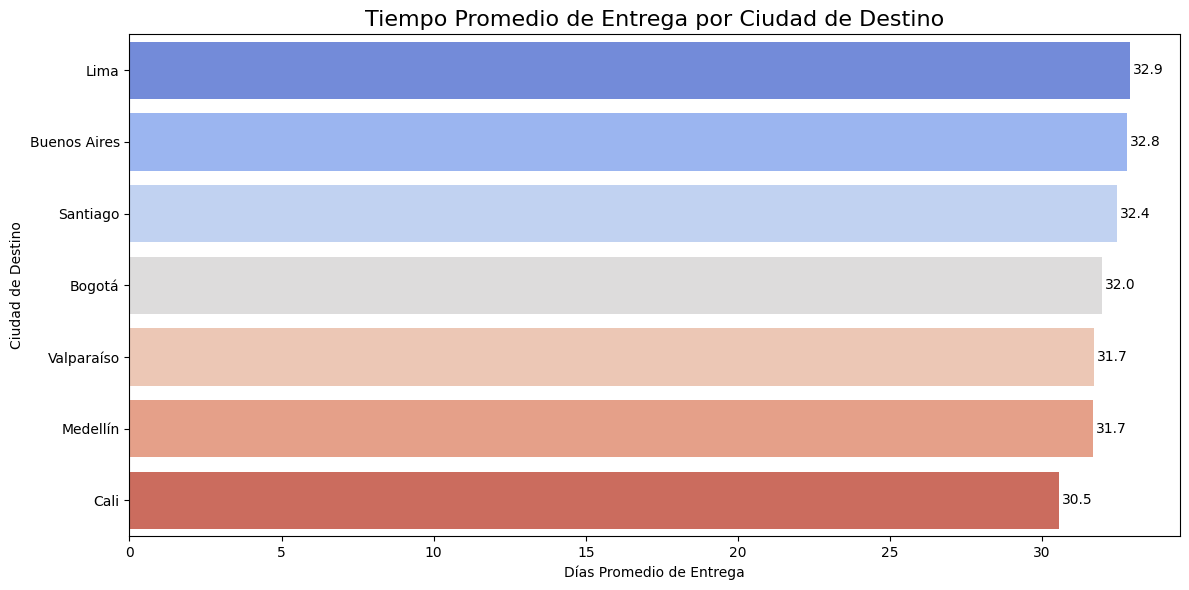

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular el promedio de tiempo de entrega por ciudad de destino
promedio_entrega = df.groupby("destino")["tiempo_entrega_real"].mean().sort_values(ascending=False)

# Configurar el estilo de la gr√°fica
plt.figure(figsize=(12, 6))
sns.barplot(x=promedio_entrega.values, y=promedio_entrega.index, palette="coolwarm")

# A√±adir t√≠tulos y etiquetas
plt.title("Tiempo Promedio de Entrega por Ciudad de Destino", fontsize=16)
plt.xlabel("D√≠as Promedio de Entrega")
plt.ylabel("Ciudad de Destino")

# Mostrar los valores en las barras
for index, value in enumerate(promedio_entrega.values):
    plt.text(value + 0.1, index, f"{value:.1f}", va='center')

plt.tight_layout()
plt.show()


A continuaci√≥n se identifican posibles variables utiles para el modelo de predicci√≥n

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Copia del dataframe original
df_ml = df.copy()

# Extraer caracter√≠sticas de fechas
df_ml["fecha_pedido"] = pd.to_datetime(df_ml["fecha_pedido"])
df_ml["mes_pedido"] = df_ml["fecha_pedido"].dt.month
df_ml["dia_pedido"] = df_ml["fecha_pedido"].dt.day
df_ml["dia_semana"] = df_ml["fecha_pedido"].dt.weekday

# Seleccionar columnas predictoras y objetivo
X = df_ml[["distancia_km", "medio_transporte", "clima", "origen", "destino", "mes_pedido", "dia_pedido", "dia_semana"]]
y = df_ml["tiempo_entrega_real"]

# Columnas categ√≥ricas
categorical_cols = ["medio_transporte", "clima", "origen", "destino"]

# Codificador para columnas categ√≥ricas
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

# Divisi√≥n del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline con RandomForest
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Entrenar modelo
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Evaluaci√≥n
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} d√≠as")
print(f"RMSE: {rmse:.2f} d√≠as")
print(f"R¬≤: {r2:.2f}")


MAE: 0.92 d√≠as
RMSE: 1.15 d√≠as
R¬≤: 1.00


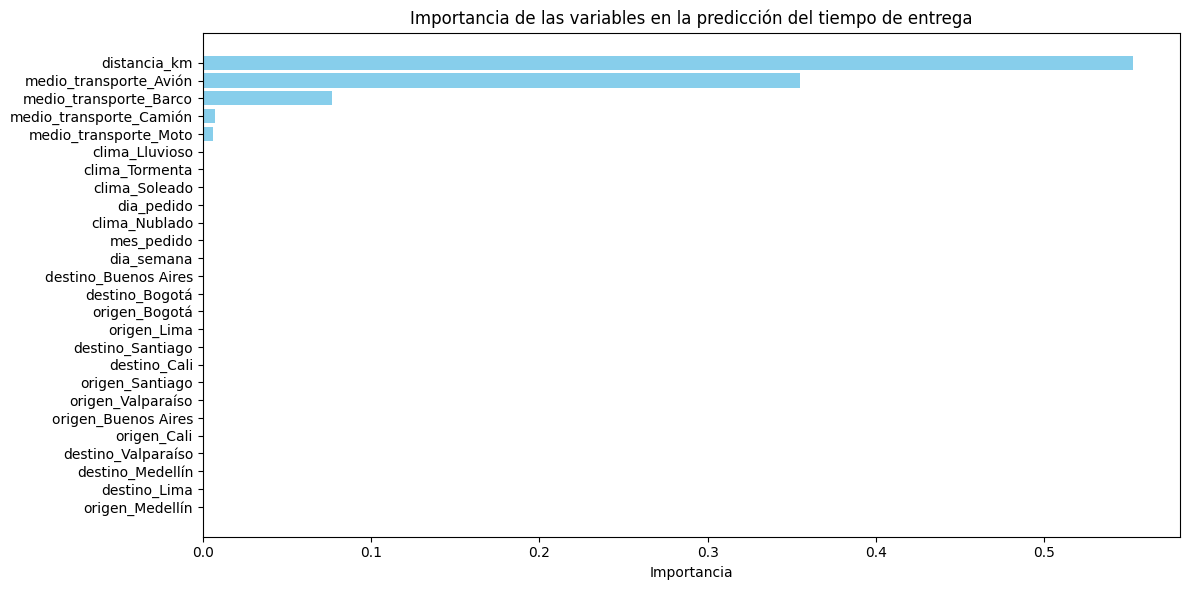

In [8]:
import matplotlib.pyplot as plt

# Extraer nombres de las columnas despu√©s del preprocesamiento
onehot_columns = model.named_steps["preprocessor"].transformers_[0][1].get_feature_names_out(categorical_cols)
feature_names = list(onehot_columns) + ["distancia_km", "mes_pedido", "dia_pedido", "dia_semana"]

# Obtener importancias del modelo
importances = model.named_steps["regressor"].feature_importances_

# Crear DataFrame de importancias
importancia_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Graficar
plt.figure(figsize=(12, 6))
plt.barh(importancia_df["feature"], importancia_df["importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.title("Importancia de las variables en la predicci√≥n del tiempo de entrega")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()


Una vez definida la importancia de las variables, evaluamos el desempe√±o de nuestro modelo utilizando una m√©trica de error, como el Error Cuadr√°tico Medio (RMSE), para ver qu√© tan preciso es el modelo.

In [9]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el RMSE (Ra√≠z del Error Cuadr√°tico Medio)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Mostrar el resultado
print(f"RMSE (Error Cuadr√°tico Medio) del modelo: {rmse:.2f} d√≠as")


RMSE (Error Cuadr√°tico Medio) del modelo: 1.15 d√≠as


Ahora se grafican las predicciones contra los valores reales, con la intenci√≥n de evaluar nuevamente la validez del modelo

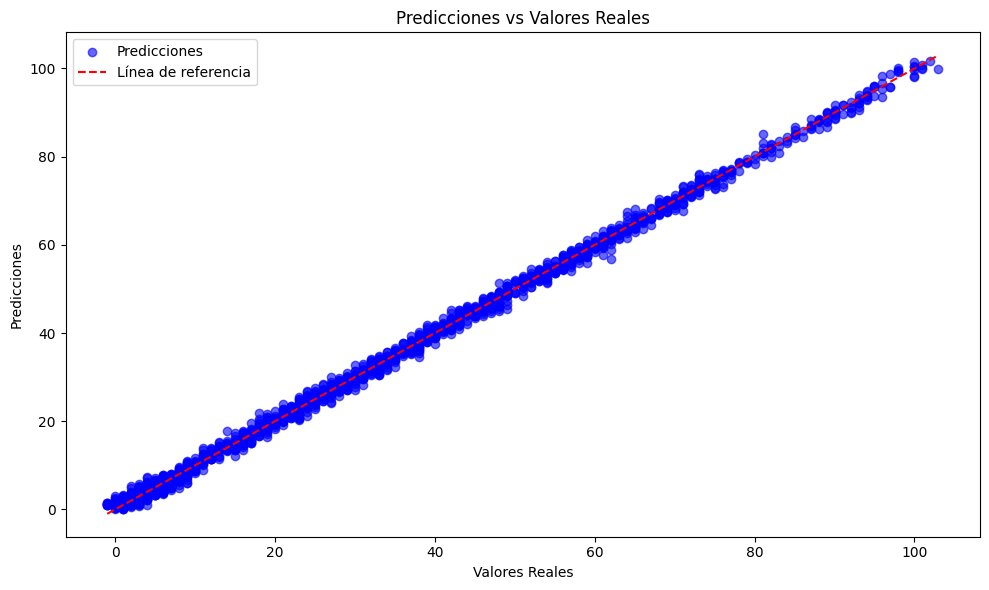

In [10]:
# Graficar las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="b", label="Predicciones")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="L√≠nea de referencia")
plt.title("Predicciones vs Valores Reales")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
import joblib

# Guardar el modelo entrenado con todo el pipeline
joblib.dump(model, "modelo_entregas_pipeline.pkl")


['modelo_entregas_pipeline.pkl']

In [19]:
# Cargar modelo entrenado
modelo_cargado = joblib.load("modelo_entregas_pipeline.pkl")

# Simular un nuevo pedido (puedes modificar estos valores)
nuevo_pedido = pd.DataFrame([{
    "distancia_km": 320.0,
    "medio_transporte": "Cami√≥n",
    "clima": "Lluvia",
    "origen": "Bogot√°",
    "destino": "Medell√≠n",
    "mes_pedido": 4,
    "dia_pedido": 23,
    "dia_semana": 2  # 0 = Lunes, 6 = Domingo
}])

# Predecir tiempo de entrega
prediccion = modelo_cargado.predict(nuevo_pedido)

print(f"üïí Tiempo de entrega estimado: {prediccion[0]:.2f} d√≠as")


üïí Tiempo de entrega estimado: 7.98 d√≠as


Creaci√≥n de una interfaz mas amigable

In [20]:
!pip install ipywidgets


   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.6/1.6 MB 18.1 MB/s eta 0:00:00


In [21]:
import pandas as pd
import joblib
import ipywidgets as widgets
from IPython.display import display


In [22]:
# Widgets para entrada de datos
distancia_widget = widgets.FloatSlider(value=100.0, min=0, max=2000, step=10, description='Distancia (km):')
medio_widget = widgets.Dropdown(options=["Cami√≥n", "Avi√≥n", "Barco", "Tren"], description='Transporte:')
clima_widget = widgets.Dropdown(options=["Soleado", "Lluvia", "Niebla", "Tormenta"], description='Clima:')
origen_widget = widgets.Dropdown(options=["Bogot√°", "Medell√≠n", "Santiago"], description='Origen:')
destino_widget = widgets.Dropdown(options=["Bogot√°", "Medell√≠n", "Santiago"], description='Destino:')
mes_widget = widgets.IntSlider(value=4, min=1, max=12, description='Mes:')
dia_widget = widgets.IntSlider(value=15, min=1, max=31, description='D√≠a:')
dia_semana_widget = widgets.Dropdown(options=[(d, i) for i, d in enumerate(["Lun", "Mar", "Mi√©", "Jue", "Vie", "S√°b", "Dom"])], description='D√≠a semana:')


In [23]:
# Cargar modelo entrenado
modelo_cargado = joblib.load("modelo_entregas_pipeline.pkl")

# Funci√≥n de predicci√≥n
def predecir_entrega(b):
    entrada = pd.DataFrame([{
        "distancia_km": distancia_widget.value,
        "medio_transporte": medio_widget.value,
        "clima": clima_widget.value,
        "origen": origen_widget.value,
        "destino": destino_widget.value,
        "mes_pedido": mes_widget.value,
        "dia_pedido": dia_widget.value,
        "dia_semana": dia_semana_widget.value
    }])

    pred = modelo_cargado.predict(entrada)[0]
    print(f"üöö Tiempo estimado de entrega: {pred:.2f} d√≠as")

# Bot√≥n de predicci√≥n
boton = widgets.Button(description="Predecir")
boton.on_click(predecir_entrega)
